# Logistics Optimization

In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext blackcellmagic
%reload_ext tensorboard
%matplotlib inline

In [2]:
import collections
import json
import math 
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from relearn.env import SimpleLogistics, Warehouse

## Logistics Provider Environment

In this example, we simulate the item delivery of a logistics provider.
We define the problem as **Dispatch items from arbitrary sellers to a logistics provider's distribution center (warehouse) where the logistics provider delivers the items to their destinations**.

To make our problem simpler, we set following assumptions:
- The distribution center operates independently so that we can define the single warehouse in our simulation.
- Items are dispatched and stored into the warehouse every day with a fixed (transportation) cost.
- Each item has one of two types of delivery: 2-day and 7-day delivery.
- There is no penalty for the dispatch failure caused by full-inventory, but there is a penalty for the late delivery.
- Items of the same destination are grouped and shipped together.

> TODO: Currently, this environment doesn't consider the route-optimization.

Here are our environment parameters:

In [3]:
NUM_STEPS = 100  # days

# Average number of items to dispatch per step
AVG_DEMAND = 20

# Number of item delivery destinations
NUM_DESTINATIONS = 10

# Distribution center capacity
WAREHOUSE_CAPACITY = 100

# Max items that can be delivered to the same location at a time
DELIVERY_CAPACITY = 5 

SEED = 1234

In [4]:
env = SimpleLogistics(
    T=NUM_STEPS,
    capacity=WAREHOUSE_CAPACITY,
    delivery_capacity=DELIVERY_CAPACITY,
    num_destinations=NUM_DESTINATIONS,
    demand_fn=AVG_DEMAND,
    seed=SEED,
)
env.render('df').head(5)

/data/anaconda/envs/relearn/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


,t,dest,due,price,penalty,dest_cost,dest_cap,t_left
0,0.0,7.0,2.0,0.5,0.25,0.801872,4.0,2.0
1,0.0,0.0,2.0,0.5,0.25,0.191519,1.0,2.0
2,0.0,9.0,2.0,0.5,0.25,0.875933,2.0,2.0
3,0.0,1.0,2.0,0.5,0.25,0.622109,3.0,2.0
4,0.0,5.0,2.0,0.5,0.25,0.272593,4.0,2.0


TODO describe about action and observation spaces

In [5]:
# Sample action
env.action_space.sample()

array([0.7010169 , 0.42397887, 0.06887916, 0.29941627, 0.51111895,
       0.9699753 , 0.33492646, 0.59682655, 0.1706354 , 0.6090652 ,
       0.2921837 , 0.6208515 , 0.15587291, 0.27452645, 0.6983987 ,
       0.03905598, 0.76551425, 0.25476748, 0.2435319 , 0.39336738,
       0.4914398 , 0.08224189, 0.5517627 , 0.9938737 , 0.6542053 ,
       0.16404204, 0.54071355, 0.38385162, 0.5490099 , 0.81185865,
       0.5662289 , 0.44125184, 0.09519856, 0.5280332 , 0.7172724 ,
       0.23485021, 0.22407095, 0.33589312, 0.69608164, 0.8716047 ,
       0.61123323, 0.5302952 , 0.6811365 , 0.3061946 , 0.11485554,
       0.14317703, 0.97852117, 0.7210616 , 0.75023   , 0.06695175,
       0.7385737 , 0.29777506, 0.8015222 , 0.10104952, 0.68461436,
       0.3046397 , 0.3955275 , 0.75806034, 0.85264987, 0.49599075,
       0.7924362 , 0.5820203 , 0.53238875, 0.0828184 , 0.939886  ,
       0.29219237, 0.25921342, 0.61027694, 0.01586226, 0.2165404 ,
       0.6234349 , 0.6434122 , 0.8770079 , 0.55229354, 0.73484

Text(0, 0.5, 'Demand')

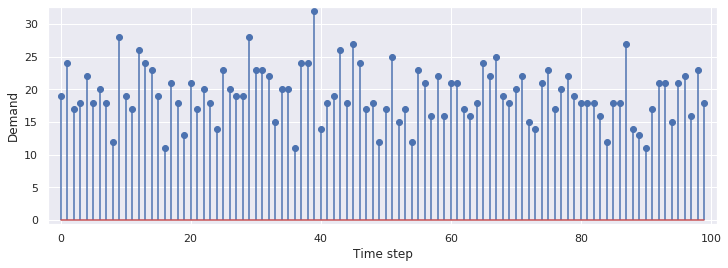

In [6]:
# Visualize demand functions
env.reset(SEED)
plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.stem([len(env.demand()) for _ in range(NUM_STEPS)], use_line_collection=True)
plt.xlabel("Time step")
plt.ylabel("Demand")

In [7]:
# Delivery costs to each destination area
env.warehouse.delivery_costs

array([0.19151945, 0.62210877, 0.43772774, 0.78535858, 0.77997581,
       0.27259261, 0.27646426, 0.80187218, 0.95813935, 0.87593263])

Text(0, 0.5, 'Profit')

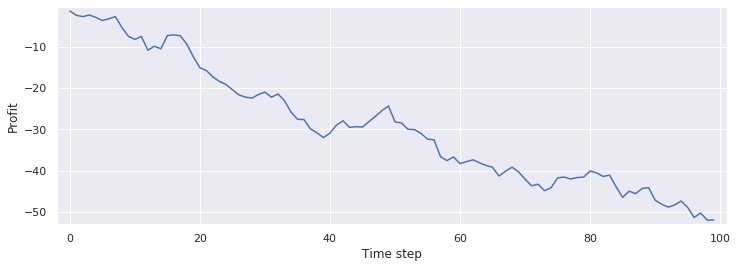

In [8]:
# Random action
env.reset(SEED)
done = False
rewards = []
while not done:
    _, reward, done, info = env.step(env.action_space.sample())
    rewards.append(reward)

plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.plot(rewards)
plt.xlabel("Time step")
plt.ylabel("Profit")

Text(0, 0.5, 'Profit')

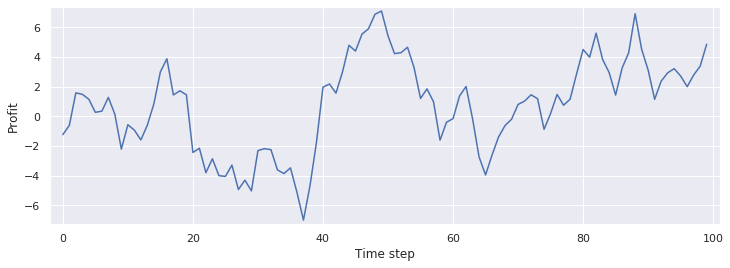

In [9]:
# First come first serve
env.reset(SEED)
done = False
rewards = []
while not done:
    delivery = [1.0] * len(env.warehouse.inventory)
    _, reward, done, info = env.step(delivery)
    rewards.append(reward)
#     print(info['num_items_failed_to_deliver'])

plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.plot(rewards)
plt.xlabel("Time step")
plt.ylabel("Profit")

In [10]:
# TODO plot demands, delivery, penalty, etc. together


## Simple Policy

In [11]:
class WaitAndDeliverPolicy:
    def __init__(
        self,
        due,
        capacity,
        delivery_capacity,
    ):
        """Wait to collect as many items as possible before delivery.
        Deliver when there are due items or reached to delivery_capacity_limit
        or capacity_limit.
        """
        self.due = due
        self.capacity = capacity
        self.delivery_capacity = delivery_capacity

    def action(self, state_df):
        """Check inventory, select items to deliver ():
        """
        full_capacity = len(state_df)
        
        # remove empty
        df = state_df.loc[state_df['price'] > 0.0]
        
        if len(df) > self.capacity:
            pass  # Try to deliver all 
        else:
            # deliver the items close to the due date and other items that have the same destinations.
            due_items = df.loc[df['t_left'] < self.due]
            areas = set(due_items['dest'])
            
            # also, include areas where the delivery capacity is full
            areas.update(df.loc[df['dest_cap'] < self.delivery_capacity]['dest'])
            
            # select the items for those areas
            df = df.loc[df['dest'].isin(areas)]
        
        ids = np.array(df.sort_values(by=['t_left','penalty'], ascending=(True,False)).index)
        ps = np.linspace(1.0, 0.9, len(df))
        
        a = [0.0] * full_capacity
        for i, p in zip(ids, ps):
            a[i] = p
        return a
        

In [12]:
wd_policy = WaitAndDeliverPolicy(
    due=1.0,
    capacity=int(WAREHOUSE_CAPACITY * 0.8),
    delivery_capacity=int(DELIVERY_CAPACITY * 0.8),
)

Text(0, 0.5, 'Profit')

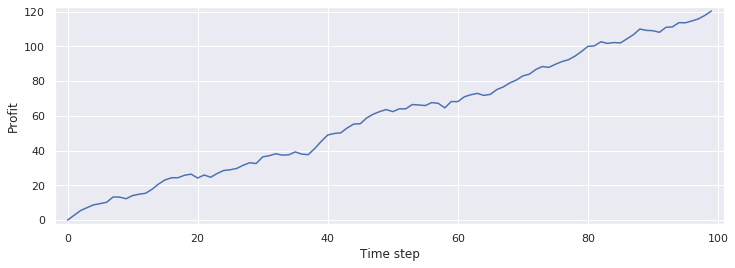

In [13]:
env.reset(SEED)
done = False
rewards = []
while not done:
    action = wd_policy.action(env.render('df'))
    _, reward, done, info = env.step(action)
    rewards.append(reward)
#     print(info['num_items_failed_to_deliver'])

plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.plot(rewards)
plt.xlabel("Time step")
plt.ylabel("Profit")

## Reinforcement Learning

In [14]:
NUM_TRAIN_STEPS = 100000
TB_ROOT = "logs"

### DDPG using Stable-Baseline

[stable-baseline](https://github.com/hill-a/stable-baselines)

* LnMlpPolicy: MLP (2 layers of 64), with layer normalisation
* NormalActionNoise: A Gaussian action noise for exploration

In [23]:
from stable_baselines import DDPG, PPO2

from stable_baselines.common.noise import NormalActionNoise
from stable_baselines.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines.ddpg import AdaptiveParamNoiseSpec
from stable_baselines.ddpg.policies import LnMlpPolicy


In [24]:
# the noise objects for DDPG
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(
    mean=np.zeros(n_actions),
    sigma=float(0.5)*np.ones(n_actions)
)
param_noise = AdaptiveParamNoiseSpec()

# Automatically normalize the input features
norm_env = VecNormalize(
    DummyVecEnv([lambda: env]),
    norm_obs=True,
    norm_reward=False,
    clip_obs=10.
)

ddpg_logpath = os.path.join(TB_ROOT, "ddpg")

ddpg = DDPG(
    LnMlpPolicy,
    norm_env,
    verbose=1,
    action_noise=action_noise,
    param_noise=param_noise,
    param_noise_adaption_interval=100,
    tensorboard_log=ddpg_logpath,
)
ddpg.learn(total_timesteps=NUM_TRAIN_STEPS)

# To save and load:
# ddpg.save("path")
# ddpg = DDPG.load("path")

--------------------------------------
| param_noise_stddev      | 0.0373   |
| reference_Q_mean        | 62.8     |
| reference_Q_std         | 29.6     |
| reference_action_mean   | 0.125    |
| reference_action_std    | 0.858    |
| reference_actor_Q_mean  | 88.1     |
| reference_actor_Q_std   | 32.5     |
| reference_perturbed_... | 0.854    |
| rollout/Q_mean          | 33.7     |
| rollout/actions_mean    | 0.0766   |
| rollout/actions_std     | 0.767    |
| rollout/episode_steps   | 100      |
| rollout/episodes        | 100      |
| rollout/return          | -137     |
| rollout/return_history  | -137     |
| total/duration          | 66.6     |
| total/episodes          | 100      |
| total/epochs            | 1        |
| total/steps             | 9998     |
| total/steps_per_second  | 150      |
| train/loss_actor        | -89.2    |
| train/loss_critic       | 79.8     |
| train/param_noise_di... | 0.202    |
--------------------------------------

------------------------


---------------------------------------
| param_noise_stddev      | 0.0165    |
| reference_Q_mean        | 760       |
| reference_Q_std         | 451       |
| reference_action_mean   | 0.0897    |
| reference_action_std    | 0.945     |
| reference_actor_Q_mean  | 816       |
| reference_actor_Q_std   | 453       |
| reference_perturbed_... | 0.944     |
| rollout/Q_mean          | 503       |
| rollout/actions_mean    | 0.106     |
| rollout/actions_std     | 0.801     |
| rollout/episode_steps   | 100       |
| rollout/episodes        | 1e+03     |
| rollout/return          | 45.4      |
| rollout/return_history  | -482      |
| total/duration          | 648       |
| total/episodes          | 1e+03     |
| total/epochs            | 1         |
| total/steps             | 99998     |
| total/steps_per_second  | 154       |
| train/loss_actor        | -1.07e+03 |
| train/loss_critic       | 2.54e+03  |
| train/param_noise_di... | 0.0901    |
---------------------------------------


---------------------------------------
| param_noise_stddev      | 0.00839   |
| reference_Q_mean        | 923       |
| reference_Q_std         | 971       |
| reference_action_mean   | -0.158    |
| reference_action_std    | 0.924     |
| reference_actor_Q_mean  | 991       |
| reference_actor_Q_std   | 972       |
| reference_perturbed_... | 0.924     |
| rollout/Q_mean          | 968       |
| rollout/actions_mean    | 0.0827    |
| rollout/actions_std     | 0.813     |
| rollout/episode_steps   | 100       |
| rollout/episodes        | 1.9e+03   |
| rollout/return          | -509      |
| rollout/return_history  | -1.58e+03 |
| total/duration          | 1.23e+03  |
| total/episodes          | 1.9e+03   |
| total/epochs            | 1         |
| total/steps             | 189998    |
| total/steps_per_second  | 154       |
| train/loss_actor        | -1.87e+03 |
| train/loss_critic       | 2.13e+03  |
| train/param_noise_di... | 0.0934    |
---------------------------------------

In [40]:
%tensorboard --logdir {ddpg_logpath}

Reusing TensorBoard on port 6006 (pid 109652), started 3:10:15 ago. (Use '!kill 109652' to kill it.)

Text(0, 0.5, 'Profit')

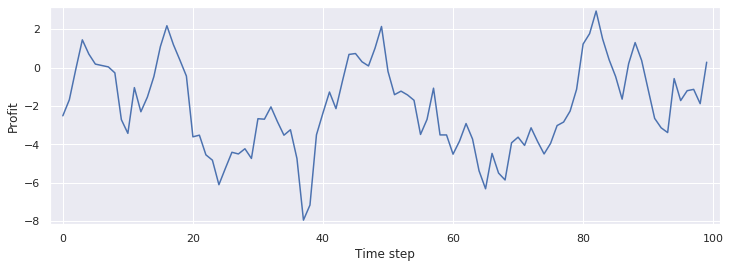

In [17]:
obs = env.reset(SEED)
done = False
rewards = []
while not done:
    action, _ = ddpg.predict(obs)
    obs, reward, done, info = env.step(action)
    rewards.append(reward)

plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.plot(rewards)
plt.xlabel("Time step")
plt.ylabel("Profit")

In [18]:
action, _ = ddpg.predict(obs)
action

array([9.9996233e-01, 8.3558464e-01, 8.4874666e-01, 9.8014492e-01,
       5.6014413e-01, 6.3973778e-01, 1.0000000e+00, 4.4553846e-01,
       9.9999994e-01, 8.8661659e-01, 9.4196290e-02, 3.3034712e-02,
       1.0000000e+00, 9.2671907e-01, 5.5999881e-01, 9.8018491e-01,
       7.1473849e-01, 9.6995705e-01, 1.6073450e-01, 9.6599424e-01,
       3.1036681e-01, 9.9844420e-01, 9.7819972e-01, 8.8032043e-01,
       6.4174950e-01, 7.1271634e-01, 9.1975909e-01, 9.9672639e-01,
       4.4275138e-01, 5.3026330e-01, 1.6015014e-01, 9.7025192e-01,
       8.0000579e-01, 1.7171171e-01, 2.2186244e-01, 6.2269443e-01,
       9.9939048e-01, 6.7342257e-01, 8.1915504e-01, 1.0571641e-01,
       6.7072654e-01, 9.5350671e-01, 3.6901504e-02, 8.1754786e-01,
       1.6521841e-01, 5.0008607e-01, 9.4276071e-03, 2.5890648e-02,
       7.3304808e-01, 1.3526848e-01, 4.4093609e-02, 3.6579466e-01,
       8.5781586e-01, 9.7641027e-01, 9.7876698e-01, 3.0641586e-02,
       9.9538994e-01, 5.8931321e-02, 8.6079115e-01, 2.6490089e

In [19]:
obs

array([[ 9.80000000e+01,  1.00000000e+00,  7.00000000e+00,
         1.42857143e-01,  2.04081633e-02,  6.22108771e-01,
         0.00000000e+00,  5.00000000e+00],
       [ 9.90000000e+01,  2.00000000e+00,  2.00000000e+00,
         5.00000000e-01,  2.50000000e-01,  4.37727739e-01,
         3.00000000e+00,  1.00000000e+00],
       [ 9.90000000e+01,  4.00000000e+00,  7.00000000e+00,
         1.42857143e-01,  2.04081633e-02,  7.79975808e-01,
         2.00000000e+00,  6.00000000e+00],
       [ 9.90000000e+01,  7.00000000e+00,  2.00000000e+00,
         5.00000000e-01,  2.50000000e-01,  8.01872178e-01,
         3.00000000e+00,  1.00000000e+00],
       [ 9.90000000e+01,  9.00000000e+00,  7.00000000e+00,
         1.42857143e-01,  2.04081633e-02,  8.75932635e-01,
        -1.00000000e+00,  6.00000000e+00],
       [ 1.00000000e+02,  4.00000000e+00,  7.00000000e+00,
         1.42857143e-01,  2.04081633e-02,  7.79975808e-01,
         2.00000000e+00,  7.00000000e+00],
       [ 1.00000000e+02,  9.000000

In [43]:
env.render("df")

,t,dest,due,price,penalty,dest_cost,dest_cap,t_left
0,98.0,6.0,2.0,0.500000,0.250000,0.276464,0.0,0.0
1,98.0,6.0,2.0,0.500000,0.250000,0.276464,0.0,0.0
2,99.0,2.0,2.0,0.500000,0.250000,0.437728,2.0,1.0
3,99.0,4.0,7.0,0.142857,0.020408,0.779976,2.0,6.0
4,99.0,7.0,2.0,0.500000,0.250000,0.801872,3.0,1.0
...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
96,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
97,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
98,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


## DDPG using Ray

In [ ]:
>>> prep = ModelCatalog.get_preprocessor(env)
>>> observation = prep.transform(raw_observation)


In [ ]:
# import numpy as np
# import gym
# from gym.spaces import Box

import ray
from ray import tune
# from ray.rllib.utils import try_import_tf
    
# import ray.rllib.agents.ppo as ppo
# from ray.tune.logger import pretty_print

# tf = try_import_tf()

# gym environment adapter for ray
class RayEnv(gym.Env):
    def __init__(self, config):
        self.env = config["env"]
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space

    def reset(self):
        return self.env.reset()

    def step(self, action):
        # TODO need to rescale the space in order to make the model train better
        # TODO see https://ray.readthedocs.io/en/latest/rllib-models.html for details.
        return self.env.step(action)

ray.shutdown()
ray.init()

config = {
    "num_gpus": 1,
    "log_level": "ERROR"
    
}
config["env_config"] = {"env": env}

trainer = ppo.PPOTrainer(config=config, env=RayEnv)
for i in range(NUM_EPISODES):
    result = trainer.train()
    print("result: {}".format(result))

In [ ]:
policy = trainer.get_policy()

In [ ]:
env.render("df")

In [ ]:
action[0]

In [ ]:
# env.render()
# obs, state, prev_action=None, prev_reward=None, info=None, episode=None, clip_actions=False

env.reset(SEED)
done = False
rewards = []
while not done:
    action = policy.compute_single_action(env.render())
    _, reward, done, info = env.step(action[0])
    rewards.append(reward)
#     print(info['num_items_failed_to_deliver'])

plt.figure(figsize=(12,4))
plt.margins(0.02)
plt.plot(rewards)
plt.xlabel("Time step")
plt.ylabel("Profit")


# Analysis and Debugging of the Policy Produced by RLlib

In [ ]:
import json

def load_policy():
    log_dir = ".../ray_results/DDPG_SimpleSupplyChain_2020-01-23_20-51-479cn5z0i0" # this path needs to be set manually
    checkpoint_id = "200"
    with open(f"{log_dir}/params.json", "r") as read_file:
        config = json.load(read_file)
    trainer = ddpg.DDPGTrainer(config=config, env=SimpleSupplyChain)
    trainer.restore(f"{log_dir}/checkpoint_{checkpoint_id}/checkpoint-{checkpoint_id}")
    return trainer.get_policy()

policy = load_policy()

# tracing the policy
env = SupplyChainEnvironment()
state = env.initial_state()
transitions_rl = []
for t in range(env.T):
    action = policy.compute_single_action( state.to_array() , state=[] ) 
    action_obj = Action(env.warehouse_num)
    action_obj.production_level = action[0][0]
    action_obj.shippings_to_warehouses = action[0][1:]
    state, reward, _ = env.step(state, action_obj)
    transitions_rl.append([state, action_obj, reward])

In [ ]:
# tracing the policy
visualize_transitions(np.array(transitions_rl))

In [ ]:
# Using Ray's tune. 
import ray
from ray import tune

ray.init()
tune.run(
    "PPO",
    stop={"episode_reward_mean": 200},
    config={
        "env": "CartPole-v0",
        "num_gpus": 0,
        "num_workers": 1,
        "lr": tune.grid_search([0.01, 0.001, 0.0001]),
        "eager": False,
    },
)
